In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用
#%matplotlib notebook

In [2]:
class DstarLite():
    def __init__(self, grid_map_world, drawCostflag=False):
        self.world = grid_map_world
        self.real_grid_map = grid_map_world.grid_map #実際のマップ
        self.metric_grid_map = np.full(self.real_grid_map.shape, '-1')  #測定により得られたマップ
        self.cost_map = np.full(self.real_grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.real_grid_map.shape, 0)
        
        self.g_map = np.full(self.real_grid_map.shape, float('inf'))
        self.rhs_map = np.full(self.real_grid_map.shape, float('inf'))
        
        self.flag_map_update = False  #マップ更新のフラグ
        self.U = []
        self.km = 0.0
        self.sLast = self.world.start_index
        self.sStart = self.world.start_index
        self.pres_index = self.world.start_index
        self.path = []
        
        self.drawCostflag = drawCostflag
        
        grid_id = 0
        for index_x, grids in enumerate(self.real_grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = grid_id;
                if(grid == '3'): #ゴール地点はコストをゼロにする
                    self.rhs_map[index_x][index_y] = 0
                    self.uAppend([index_x, index_y], [self.h(self.sStart, self.world.goal_index), 0])
                grid_id += 1
        self.computeShortestPath()
    
    def draw(self, ax, elems):
        if(self.sStart == self.world.goal_index):
            return
        #if(self.g(self.sStart) == float('inf')):
        #    return
        
        robot_index = self.moveRobot()
        
        #コストの描画
        if(self.drawCostflag):
            #cost_adj = 13   #map_2
            #cost_adj = 16   #map_3
            #cost_adj = 4    #map_large
            cost_adj = 13  
            #self.drawCost(ax, elems, cost_adj)
        
        self.drawRobot(ax, elems)
        self.checkNewObstacle(ax, elems)
        self.getPath(robot_index)
        self.drawPath(ax, elems)        
    
    def moveRobot(self):
        #ロボットの移動
        min_cost = float('inf')
        robot_index = self.sStart
        for s_dash in self.listNeigbor(self.sStart):
            if(min_cost >= self.c(self.sStart, s_dash) + self.g(s_dash)):
                #if(self.pres_index != s_dash):
                min_cost = self.c(self.sStart, s_dash) + self.g(s_dash)
                robot_index = s_dash
        self.sStart = robot_index
        return robot_index
    
    def checkNewObstacle(self, ax, elems):
        #新しく障害物が見つかったかどうかを確認する
        self.flag_map_update = False
        for i in range(-3, 6):
                if(self.sStart[0]+i<0 or self.sStart[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-3, 6):
                    if((self.sStart[1]+j<0 or self.sStart[1]+j>self.cost_map.shape[1]-1) or (i==0 and j==0) or (math.sqrt(i**2+j**2) >= 3)):
                        continue
                    else:
                        u = [self.sStart[0]+i, self.sStart[1]+j]
                        if(self.metric_grid_map[u[0]][u[1]] == '-1'):  #まだ探索していないグリッドの場合
                            self.metric_grid_map[u[0]][u[1]] = self.real_grid_map[u[0]][u[1]]
                            if(self.real_grid_map[u[0]][u[1]] == '0'):  #新しい障害物の場合
                                self.flag_map_update = True
                                r = patches.Rectangle(
                                    xy=((self.sStart[0]+i)*self.world.grid_step[0], (self.sStart[1]+j)*self.world.grid_step[1]),
                                    height=self.world.grid_step[0],
                                    width=self.world.grid_step[1],
                                    color="black",
                                    fill=True
                                )
                                ax.add_patch(r)

                                #周囲のグリッドをオープンリストに追加する
                                for v in self.listNeigbor(u):
                                    c_old = 1.41421356 if(math.sqrt((u[0]-v[0])**2 + (u[1]-v[1])**2) > 1.4) else 1.0
                                    if(c_old > self.c(u, v)):
                                        if(u != self.world.goal_index):
                                            self.rhs_map[u[0]][u[1]] = min(self.rhs(u), self.c(u, v)+self.g(v))
                                    elif(self.rhs(u) == c_old + self.g(v)):
                                        if(u != self.world.goal_index):
                                            self.rhs_map[u[0]][u[1]] = self.getMinRhs(u)
                                    self.updateVertex(u)
                                    
                                    if(c_old > self.c(v, u)):
                                        if(v != self.world.goal_index):
                                            self.rhs_map[v[0]][v[1]] = min(self.rhs(v), self.c(v, u)+self.g(u))
                                    elif(self.rhs(v) == c_old + self.g(u)):
                                        if(v != self.world.goal_index):
                                            self.rhs_map[v[0]][v[1]] = self.getMinRhs(v)
                                    self.updateVertex(v)
                        else:
                            pass
                        
        if(self.flag_map_update):
            self.km = self.km + self.h(self.sLast, self.sStart)
            self.sLast = self.sStart
            self.computeShortestPath()
    
    def getPath(self, robot_index):#今後の経路を描画
        self.path = []
        while(robot_index != self.world.goal_index):
            next_index = robot_index
            #print(next_index)
            min_cost = float('inf')
            for s_dash in self.listNeigbor(next_index):
                if(self.metric_grid_map[s_dash[0]][s_dash[1]] == '0'):
                    continue
                #print("\t", s_dash, self.c(robot_index, s_dash), self.rhs(s_dash), min_cost, self.c(robot_index, s_dash) + self.g(s_dash))
                if(min_cost >= self.c(robot_index, s_dash) + self.rhs(s_dash)):
                    min_cost = self.c(robot_index, s_dash) + self.rhs(s_dash)
                    next_index = s_dash
            if(robot_index == next_index):
                break
            robot_index = next_index
            self.path.append(robot_index)
    
    def computeShortestPath(self):
        while(1):
            U_row = [row[1] for row in self.U]
            u_data = min(U_row)
            idx = U_row.index(u_data)
            u, k_old = self.U[idx]
            k_new = self.calculateKey(u)
                
            if(k_old >= self.calculateKey(self.sStart) and self.rhs(self.sStart) <= self.g(self.sStart)):
                break
            
            if(k_old < k_new):
                self.uUpdate(u, k_new)
            elif(self.g(u) > self.rhs(u)):
                self.g_map[u[0]][u[1]] = self.rhs(u)
                self.uRemove(u)
                for s in self.listNeigbor(u):
                    if(s != self.world.goal_index):
                        self.rhs_map[s[0]][s[1]] = min(self.rhs(s), self.c(s, u)+self.g(u))
                    self.updateVertex(s)
            else:
                g_old = self.g(u)
                self.g_map[u[0]][u[1]] = float('inf')
                neigbors = self.listNeigbor(u)
                neigbors.append(u)
                for s in neigbors:
                    if(self.rhs(s) == self.c(s, u) + g_old):
                        if(s != self.world.goal_index):
                            self.rhs_map[s[0]][s[1]] = self.getMinRhs(s)
                    self.updateVertex(s)
    
    def calculateKey(self, s):
        return [min(self.g(s), self.rhs(s)) + self.h(self.world.start_index, s) + self.km, min(self.g(s), self.rhs(s))]
    
    def updateVertex(self, u):
        u_flag = u in [row[0] for row in self.U]
        if(self.g(u) != self.rhs(u) and u_flag):
            self.uUpdate(u, self.calculateKey(u))
        elif(self.g(u) != self.rhs(u) and u_flag == False):
            self.uAppend(u, self.calculateKey(u))
        elif(self.g(u) == self.rhs(u) and u_flag):
            self.uRemove(u)
    
    def isU(self, u):
        U_row = [row[0] for row in self.U]
        return u in U_row
    
    def uAppend(self, u, u_num):
        self.U.append([u, u_num])
    
    def uRemove(self, u):
        U_row = [row[0] for row in self.U]
        idx = U_row.index(u)
        self.U.remove([u, self.U[idx][1]])
    
    def uUpdate(self, u, u_num_new):
        U_row = [row[0] for row in self.U]
        idx = U_row.index(u)
        self.U[idx][1] = u_num_new
            
    def listNeigbor(self, u):
        neigbor_indexes = []
        for i in range(-1, 2):
                if(u[0]+i<0 or u[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-1, 2):
                    if((u[1]+j<0 or u[1]+j>self.cost_map.shape[1]-1) or (i==0 and j==0)):
                        continue
                    neigbor_indexes.append([u[0]+i, u[1]+j])
        return neigbor_indexes
    
    def getMinRhs(self, u):
        min_rhs = float('inf')
        for v in self.listNeigbor(u):
            if(min_rhs > self.c(u, v)+self.g(v)):
                min_rhs = self.c(u, v)+self.g(v)
        return min_rhs
               
    def rhs(self, s):
        return self.rhs_map[s[0]][s[1]]
    
    def g(self, s):
        return self.g_map[s[0]][s[1]]
    
    def c(self, index, neigbor_index): #隣接ノードへ移動するのに要するコスト
        if(self.metric_grid_map[index[0]][index[1]] == '0' or self.metric_grid_map[neigbor_index[0]][neigbor_index[1]] == '0'):
            return float('inf')
        else:
            return 1.41421356 if(math.sqrt((index[0]-neigbor_index[0])**2 + (index[1] - neigbor_index[1])**2) > 1.4) else 1.0

    def h(self, s1, s2):
        return 1.0*math.sqrt((s1[0]-s2[0])**2+(s1[1]-s2[1])**2)            
    
    def drawPath(self, ax, elems):
        for n in self.path:
            if(n != self.world.start_index and n != self.world.goal_index):
                r = patches.Rectangle(
                    xy=((n[0])*self.world.grid_step[0], (n[1])*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color="red",
                    alpha = 0.5,
                    fill=True
                )
                elems.append(ax.add_patch(r))
    
    def drawCost(self, ax, elems, cost_adj):
        for index_x, grids in enumerate(self.metric_grid_map):
            for index_y, grid in enumerate(grids):
                if(self.rhs([index_x, index_y]) < 100000):    #LOWER状態のセルを描画
                    c_num = int(self.rhs([index_x, index_y])) #Black→Blue
                    c_num = int(c_num * cost_adj)
                    if(c_num > 0xff): #Blue → Cyan
                        c_num = (c_num-0xff)*16*16 + 0xff
                        if(c_num > 0xffff): #Cyan → Green
                            c_num = 0xffff - int((c_num-0x100ff)*4/256)
                            if(c_num < 0xff00): #Green →Yellow
                                c_num = (0xff00-c_num)*65536+0xff00
                                if(c_num > 0xffff00): #Yellow → Red
                                    c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                    fill = True
                    alpha = 0.5
                    c = '#' + format(int(c_num), 'x').zfill(6)

                    r = patches.Rectangle(
                        xy=((index_x)*self.world.grid_step[0], (index_y)*self.world.grid_step[1]),
                        height=self.world.grid_step[0],
                        width=self.world.grid_step[1],
                        color=c,
                        fill=fill,
                        alpha=alpha
                    )
                    if(self.sStart == self.world.goal_index):
                        ax.add_patch(r)
                    else:
                        elems.append(ax.add_patch(r))
                else:    #RAISE状態のセルを描画
                    #r = patches.Rectangle(
                    #    xy=((index_x)*self.world.grid_step[0], (index_y)*self.world.grid_step[1]),
                    #    height=self.world.grid_step[0],
                    #    width=self.world.grid_step[1],
                    #    color='red',
                    #    fill=True,
                    #    alpha=1.0
                    #)
                    #elems.append(ax.add_patch(r))
                    continue;

    def drawRobot(self, ax, elems):
        #ロボットと通過経路の描画
        if(self.sStart != self.world.start_index and self.sStart != self.world.goal_index):
            r = patches.Rectangle(
                xy=((self.sStart[0])*self.world.grid_step[0], (self.sStart[1])*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="magenta",
                alpha = 0.5,
                fill=True
            )
            ax.add_patch(r)
        r = patches.Rectangle(
            xy=((self.sStart[0])*self.world.grid_step[0], (self.sStart[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color="blue",
            fill=True
        )
        elems.append(ax.add_patch(r))

<IPython.core.display.Javascript object>


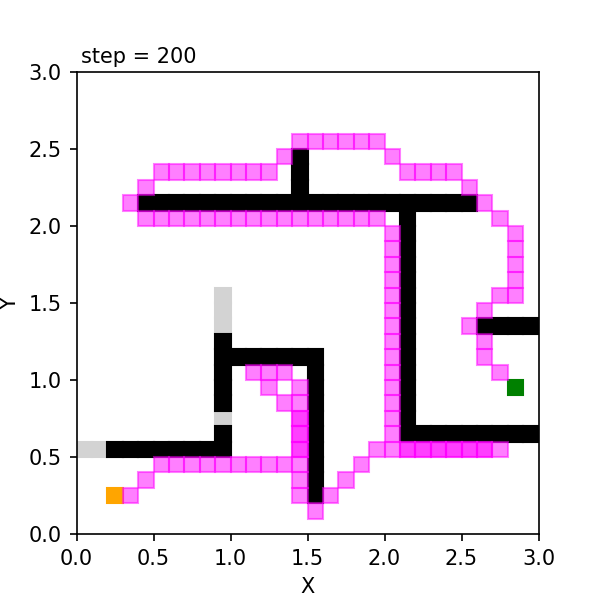

In [3]:
if __name__ == "__main__":
    time_span = 20
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False, isDynamic=True)
    world.append(DstarLite(world))
    
    world.draw()
    #world.ani.save('dstarlite_map5.gif', writer='pillow', fps=100)    #アニメーション保存